# Task 5: pixel pendulum
Sam Greydanus

In [1]:
# import numpy as np
# import torch, sys, io
# import matplotlib.pyplot as plt
# from IPython import display
# from PIL import Image, ImageDraw, ImageSequence, ImageFont
# import scipy, scipy.misc, scipy.integrate
# solve_ivp = scipy.integrate.solve_ivp

# EXPERIMENT_DIR = './experiment-pixels'
# sys.path.append(EXPERIMENT_DIR)

# from data import get_dataset, make_gym_dataset, sample_gym, hamiltonian_fn
# from nn_models import MLPAutoencoder, MLP
# from hnn import HNN, PixelHNN
# from utils import make_gif, L2_loss, integrate_model

import numpy as np
import torch, sys, io
import matplotlib.pyplot as plt
from IPython import display
from PIL import Image, ImageDraw, ImageSequence, ImageFont
import scipy, scipy.integrate
solve_ivp = scipy.integrate.solve_ivp

EXPERIMENT_DIR = './experiment-pixels'
sys.path.append(EXPERIMENT_DIR)

from data import get_dataset, make_gym_dataset, sample_gym, hamiltonian_fn
from nn_models import MLPAutoencoder, MLP
from hnn import HNN, PixelHNN

# Reload the updated utils module to ensure the latest changes are applied
import importlib
import utils
importlib.reload(utils)

from utils import make_gif, L2_loss, integrate_model

## Set some notebook constants

In [2]:
DPI = 300
LINE_SEGMENTS = 20
LINE_WIDTH = 2
FORMAT = 'pdf'

def get_args():
    return {'input_dim': 2*28*28,
         'hidden_dim': 200,
         'latent_dim': 2,
         'learn_rate': 1e-3,
         'nonlinearity': 'Tanh',
         'total_steps': 2000,
         'print_every': 200,
         'num_frames': 400,
         'name': 'pixels',
         'seed': 0,
         'save_dir': './{}'.format(EXPERIMENT_DIR),
         'fig_dir': './figures'}

class ObjectView(object):
    def __init__(self, d): self.__dict__ = d

Successfully loaded data from ././experiment-pixels/pendulum-pixels-dataset.pkl


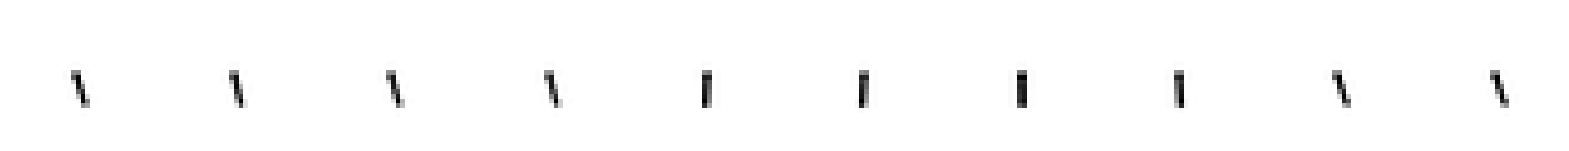

In [3]:
# Load the dataset
args = ObjectView(get_args())
data = get_dataset('pendulum', args.save_dir, verbose=False)
side = data['meta']['side']  # Ensure this matches your dataset creation
timesteps = data['meta']['timesteps']

# Retrieve and reshape a few samples
num_samples = 10  # Number of samples to visualize
sample_indices = np.random.choice(len(data['pixels']), num_samples, replace=False)
sample_images = data['pixels'][sample_indices].reshape(-1, side, side)

# Plot the images
fig, axes = plt.subplots(1, num_samples, figsize=(num_samples * 2, 2))
for i, ax in enumerate(axes):
    ax.imshow(sample_images[i], cmap='gray')
    ax.axis('off')
plt.show()

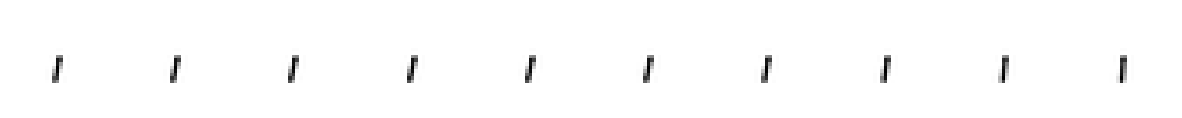

In [11]:
import pickle
import matplotlib.pyplot as plt

# Load the dataset
with open('./experiment-pixels/pendulum-pixels-dataset.pkl', 'rb') as f:
    data = pickle.load(f)

# Extract a few frames
side = data['meta']['side']
frames = data['pixels'][:,:side**2].reshape(-1, side, side)[:10]

# Display the frames
fig, axes = plt.subplots(1, 10, figsize=(15, 15))
for i, frame in enumerate(frames):
    axes[i].imshow(frame, cmap='gray')
    axes[i].axis('off')
plt.show()


Making a dataset of pendulum pixel observations.
Edit 5/28/19: you may have to rewrite the `preproc` function depending on your screen size.
        Called reset. Max angle= 2.372
        Called reset. Max angle= 0.039


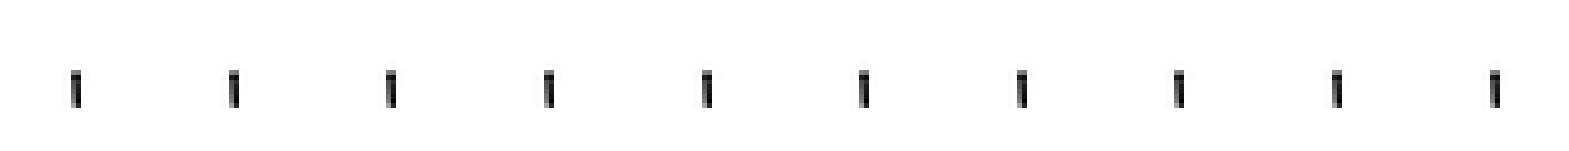

In [13]:
import gym
import numpy as np
import matplotlib.pyplot as plt

def preproc(X, side):
    '''Preprocess an image for input into the model'''
    from PIL import Image
    img = Image.fromarray(X).convert('L') 
    img = img.resize((int(side), side), Image.Resampling.LANCZOS)
    return np.array(img).flatten() / 255.0  # Flatten the image to a 1D array

def get_theta(obs):
    '''Transforms coordinate basis from the defaults of the gym pendulum env.'''
    if isinstance(obs, tuple):
        obs = obs[0]  # Extract the observation array from the tuple
    theta = np.arctan2(obs[0], -obs[1])
    theta = theta + np.pi/2
    theta = theta + 2 * np.pi if theta < -np.pi else theta
    theta = theta - 2 * np.pi if theta > np.pi else theta
    return theta

def sample_gym(seed=0, timesteps=103, trials=200, side=28, min_angle=0., max_angle=np.pi/6, verbose=False, env_name='Pendulum-v1'):
    '''Samples observations from the gym environment.'''
    gym_settings = locals()
    if verbose:
        print("Making a dataset of pendulum pixel observations.")
        print("Edit 5/28/19: you may have to rewrite the `preproc` function depending on your screen size.")
    env = gym.make(env_name, render_mode='rgb_array')
    env.reset() ; env.action_space.seed(seed)
    
    canonical_coords, frames = [], []
    for step in range(trials*timesteps):
        if step % timesteps == 0:
            angle_ok = False
            while not angle_ok:
                obs, info = env.reset()
                theta_init = np.abs(get_theta(obs))
                if verbose:
                    print("        Called reset. Max angle= {:.3f}".format(theta_init))
                if min_angle <= theta_init < max_angle:
                    angle_ok = True
        frame = env.render()
        frames.append(preproc(frame, side))
    
    return {
        'canonical_coords': np.array(canonical_coords).reshape(trials, timesteps, -1),
        'frames': np.array(frames).reshape(trials, timesteps, -1),
        'gym_settings': gym_settings
    }

# Example to check the frames
sampled_data = sample_gym(trials=1, timesteps=10, verbose=True)
sampled_images = sampled_data['frames'].reshape(-1, side, side)

# Plot the sampled images
fig, axes = plt.subplots(1, 10, figsize=(20, 2))
for i, ax in enumerate(axes):
    ax.imshow(sampled_images[i], cmap='gray')
    ax.axis('off')
plt.show()


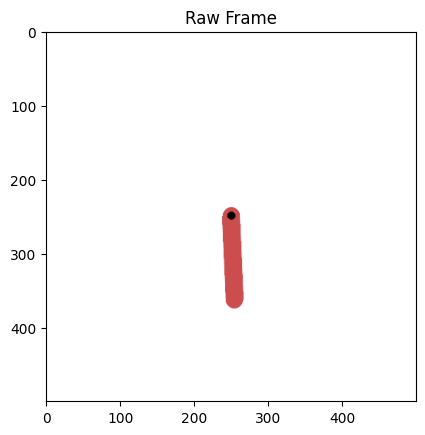

In [14]:
import gym
import matplotlib.pyplot as plt

# Create the environment
env = gym.make('Pendulum-v1', render_mode='rgb_array')
obs, info = env.reset()
raw_frame = env.render()

# Display the raw frame
plt.imshow(raw_frame)
plt.title('Raw Frame')
plt.show()


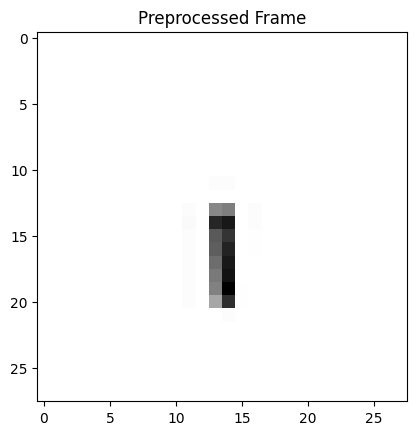

In [15]:
def preproc(X, side):
    '''Preprocess an image for input into the model'''
    from PIL import Image
    img = Image.fromarray(X).convert('L') 
    img = img.resize((int(side), side), Image.Resampling.LANCZOS)
    return np.array(img).flatten() / 255.0  # Flatten the image to a 1D array

# Process the raw frame
preprocessed_frame = preproc(raw_frame, side=28).reshape(28, 28)

# Display the preprocessed frame
plt.imshow(preprocessed_frame, cmap='gray')
plt.title('Preprocessed Frame')
plt.show()

Original image size: (500, 500)
Resized image size: (28, 28)
Length of the flattened image: 784


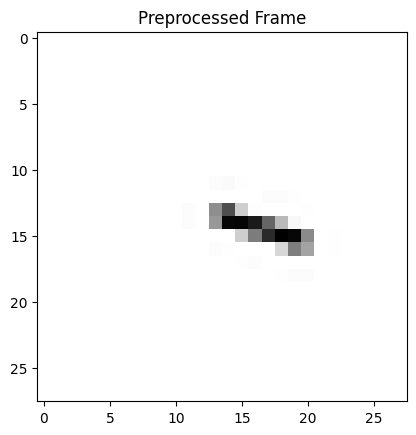

In [49]:
import gym
import matplotlib.pyplot as plt



def preproc(X, side):
    '''Preprocess an image for input into the model'''
    from PIL import Image
    img = Image.fromarray(X).convert('L')  # Convert to grayscale
    print(f"Original image size: {img.size}")
    img = img.resize((side, side), Image.Resampling.LANCZOS)
    print(f"Resized image size: {img.size}")
    return np.array(img).flatten() / 255.0  # Flatten the image to a 1D array

# Process the raw frame
preprocessed_frame = preproc(raw_frame, side=28)

# Check the length of the flattened image
print(f"Length of the flattened image: {len(preprocessed_frame)}")

# Display the preprocessed frame
plt.imshow(preprocessed_frame.reshape(28, 28), cmap='gray')
plt.title('Preprocessed Frame')
plt.show()


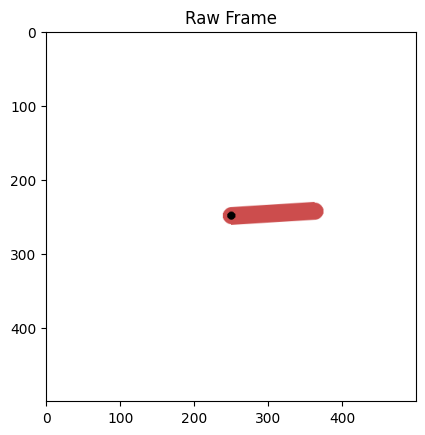

Original image size: (500, 500)
Resized image size: (28, 28)
Length of the flattened image: 784


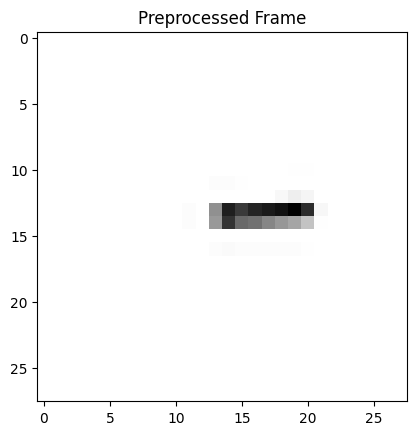

In [16]:
import gym
import matplotlib.pyplot as plt

# Create the environment
env = gym.make('Pendulum-v1', render_mode='rgb_array')
obs, info = env.reset()
raw_frame = env.render()

# Display the raw frame
plt.imshow(raw_frame)
plt.title('Raw Frame')
plt.show()

def preproc(X, side):
    '''Preprocess an image for input into the model'''
    from PIL import Image
    img = Image.fromarray(X).convert('L')  # Convert to grayscale
    print(f"Original image size: {img.size}")
    img = img.resize((side, side), Image.Resampling.LANCZOS)
    print(f"Resized image size: {img.size}")
    return np.array(img).flatten() / 255.0  # Flatten the image to a 1D array

# Process the raw frame
preprocessed_frame = preproc(raw_frame, side=28)

# Check the length of the flattened image
print(f"Length of the flattened image: {len(preprocessed_frame)}")

# Display the preprocessed frame
plt.imshow(preprocessed_frame.reshape(28, 28), cmap='gray')
plt.title('Preprocessed Frame')
plt.show()


## Make a GIF from frames in the dataset

Successfully loaded data from ././experiment-pixels/pendulum-pixels-dataset.pkl


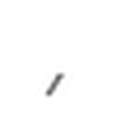

In [4]:
args = ObjectView(get_args())

# load dataset
data = get_dataset('pendulum', args.save_dir, verbose=False)
side = data['meta']['side']
trials = data['meta']['trials']
timesteps = data['meta']['timesteps']

frames = data['pixels'][:,:side**2].reshape(-1, side, side)[:args.num_frames]
name = '{}-dataset'.format(args.name)
gifname = make_gif(frames, args.fig_dir, name=name, duration=1e-1, pixels=[120,120])

display.Image(filename=gifname, width=200)

## Construct models

In [6]:
def load_model(args, baseline=False):
#     args.latent_dim = 4 if baseline else 8
    autoencoder = MLPAutoencoder(args.input_dim, args.hidden_dim,
                                     args.latent_dim, nonlinearity='ReLU')
    model = PixelHNN(args.latent_dim, args.hidden_dim, autoencoder,
                     nonlinearity=args.nonlinearity, baseline=baseline)

    case = 'baseline' if baseline else 'hnn'
    path = "{}/pixels-pixels-{}.tar".format(args.save_dir, case)
    model.load_state_dict(torch.load(path))
    return model

base_model = load_model(args, baseline=True)
hnn_model = load_model(args, baseline=False)

## How good is the autoencoder?

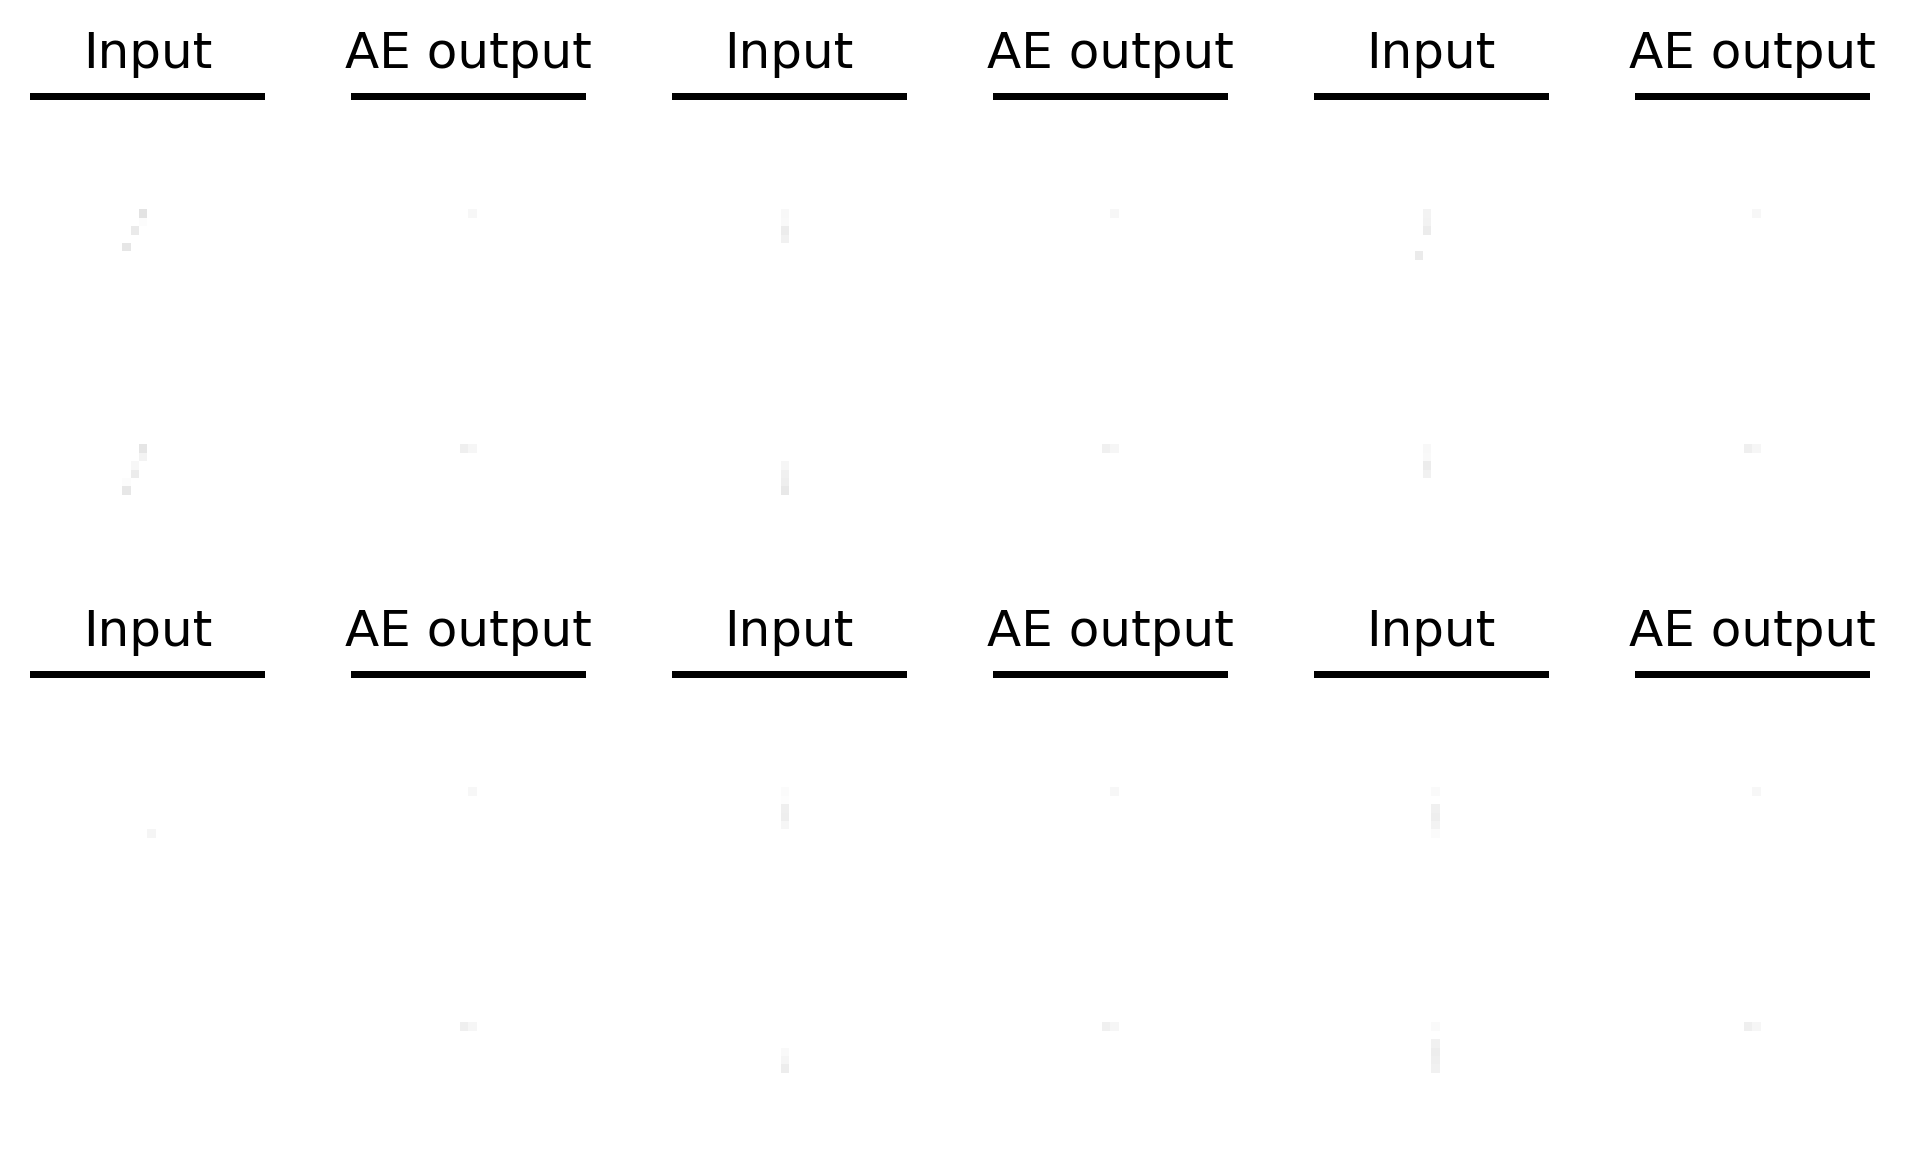

In [7]:
rows, cols = 2, 3
fig = plt.figure(figsize=[1.1*2*cols, 2*rows], dpi=DPI)

x = torch.tensor( data['pixels'], dtype=torch.float32)
x_next = torch.tensor( data['next_pixels'], dtype=torch.float32)

ixs = torch.randperm(x.shape[0])[:2*rows*cols]
bx, bx_next = x[ixs], x_next[ixs]
bx_hat_next = hnn_model.autoencoder(bx_next)

for r in range(rows):
  for c in range(cols):
    ix = r*2*cols + 2*c
    
    plt.subplot(rows, 2*cols, ix + 1)
    im = bx_next[ix].detach().numpy().reshape(-1,side)
    im = (im.clip(-.5,.5) + .5)
    im[0,:] = 0 ; im[1,:] = 1
    plt.imshow(im, cmap='gray') ; plt.axis('off') ; plt.title("Input")
    
    
    plt.subplot(rows, 2*cols, ix + 2)
    im = bx_hat_next[ix].detach().numpy().reshape(-1,side)
    im = (im.clip(-.5,.5) + .5)
    im[0,:] = 0 ; im[1,:] = 1
    plt.imshow(im, cmap='gray') ; plt.axis('off') ; plt.title("AE output")
    
plt.tight_layout() ; plt.show()
fig.savefig('{}/autoencoder-hnn.{}'.format(args.fig_dir, FORMAT))

## How does the latent space look?

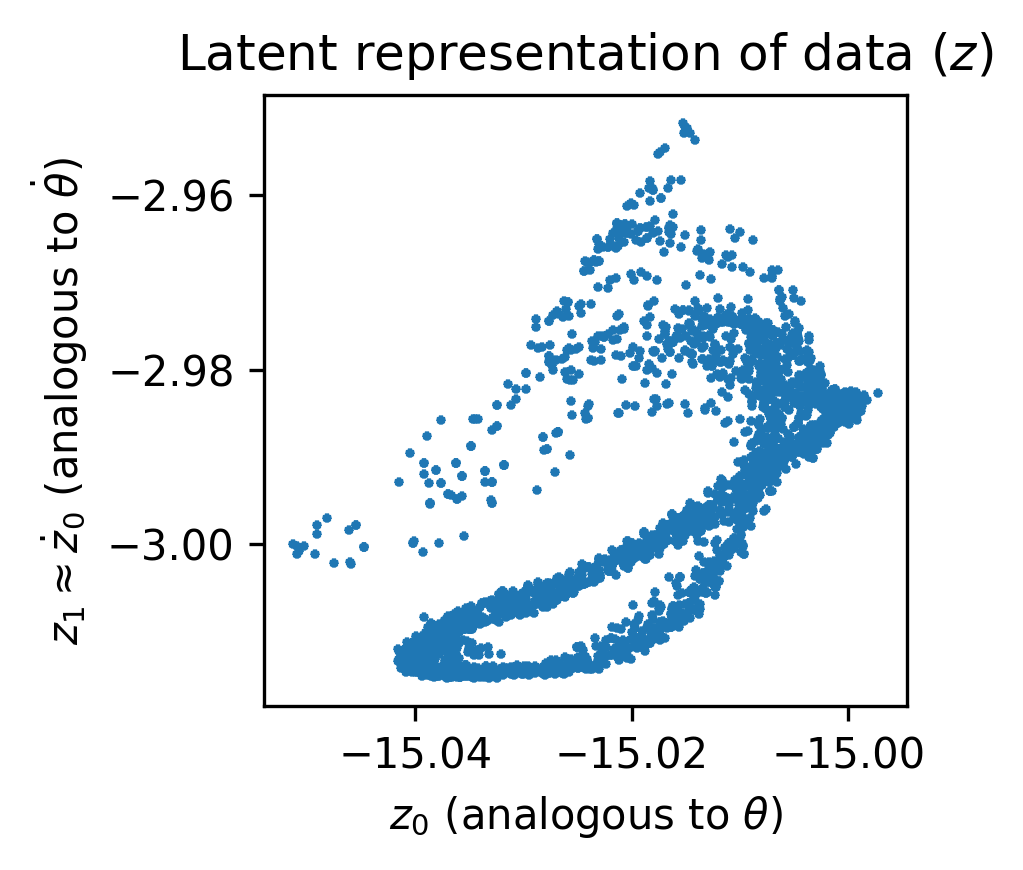

In [8]:
k = 3000
fig = plt.figure(figsize=(3.25, 3), facecolor='white', dpi=DPI)
ax = fig.add_subplot(1, 1, 1, frameon=True)
latents = hnn_model.encode(x).detach().numpy()
plt.plot(latents[:k,0], latents[:k,1], '*', markersize=2)

ax.set_xlabel("$z_0$ (analogous to $\\theta$)")
ax.set_ylabel("$z_1 \\approx \dot z_0$ (analogous to $\dot \\theta$)")
plt.title("Latent representation of data ($z$)")

plt.tight_layout() ; plt.show()
fig.savefig('{}/latents-hnn.{}'.format(args.fig_dir, FORMAT))

## Compare to actual angular quantities

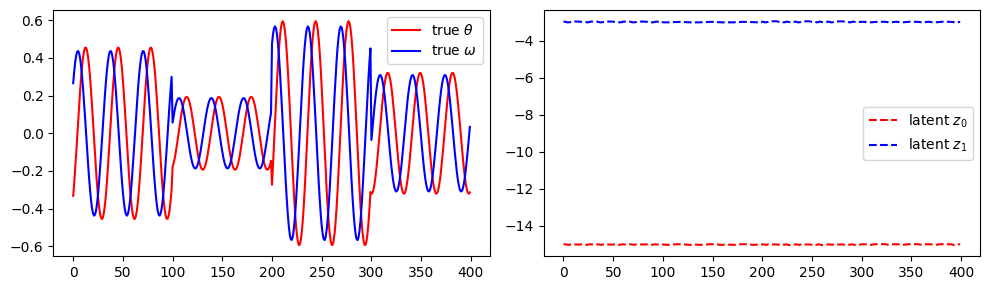

In [9]:
k = 400
fig = plt.figure(figsize=[10,3], dpi=100)
plt.subplot(1,2,1)
plt.plot(data['coords'][:k,0], "r-", label='true $\\theta$')    # ground truth coordinates (theta and omega)
plt.plot(data['coords'][:k,1], "b-", label='true $\omega$')
plt.legend()

plt.subplot(1,2,2)
plt.plot(latents[:k,0], "r--", label='latent $z_0$')   # learned by autoencoder (in an unsupervised manner)
plt.plot(latents[:k,1], "b--", label='latent $z_1$')
plt.legend()

plt.tight_layout() ; plt.show()

## Plot phase space

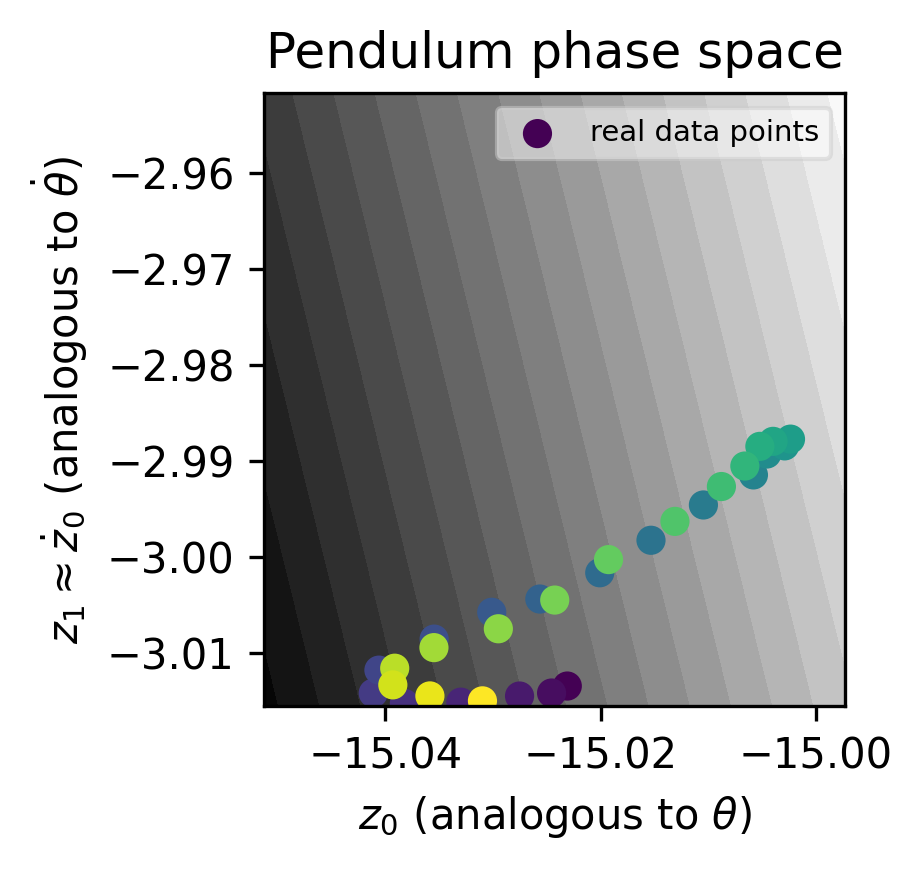

In [10]:
# # set domain
# gs = 50
# xmin, xmax = latents[:,0].min(), latents[:,0].max()
# vmin, vmax = latents[:,1].min(), latents[:,1].max()

# # feed through HNN model
# gX, gV = np.meshgrid(np.linspace(xmin, xmax, gs), np.linspace(vmin, vmax, gs))
# np_mesh_inputs = np.stack([gX.flatten(), gV.flatten()]).T
# mesh_inputs = torch.tensor( np_mesh_inputs, requires_grad=True, dtype=torch.float32)

# # get scalar fields
# F1, F2 = hnn_model.hnn(mesh_inputs)
# np_F1, np_F2 = F1.data.numpy().reshape(gs,gs), F2.data.numpy().reshape(gs,gs)

# # plot phase space
# fig = plt.figure(figsize=(3.15, 3), facecolor='white', dpi=DPI)
# ax = fig.add_subplot(1, 1, 1, frameon=True)
# plt.contourf(gX, gV, np_F2, cmap='gray_r', levels=20)
# ax.set_xlabel("$z_0$ (analogous to $\\theta$)")
# ax.set_ylabel("$z_1 \\approx \dot z_0$ (analogous to $\dot \\theta$)")
# plt.title("Pendulum phase space")

# # plot data points
# k = 30 ; t = 100
# c = np.linspace(0, 10, k)
# plt.scatter(latents[:,0][t:t+k], latents[:,1][t:t+k], c=c, cmap='viridis', label='real data points')

# plt.legend(fancybox=True, framealpha=.5, fontsize=7)
# plt.tight_layout() ; plt.show()
# fig.savefig('{}/learned-phase-space.{}'.format(args.fig_dir, FORMAT))

# set domain
gs = 50
xmin, xmax = latents[:,0].min(), latents[:,0].max()
vmin, vmax = latents[:,1].min(), latents[:,1].max()

# feed through HNN model
gX, gV = np.meshgrid(np.linspace(xmin, xmax, gs), np.linspace(vmin, vmax, gs))
np_mesh_inputs = np.stack([gX.flatten(), gV.flatten()]).T
mesh_inputs = torch.tensor(np_mesh_inputs, requires_grad=True, dtype=torch.float32)

# get scalar fields
F1, F2 = hnn_model.time_derivative(mesh_inputs).split(1, dim=1)
np_F1, np_F2 = F1.data.numpy().reshape(gs, gs), F2.data.numpy().reshape(gs, gs)

# plot phase space
fig = plt.figure(figsize=(3.15, 3), facecolor='white', dpi=DPI)
ax = fig.add_subplot(1, 1, 1, frameon=True)
plt.contourf(gX, gV, np_F2, cmap='gray_r', levels=20)
ax.set_xlabel("$z_0$ (analogous to $\\theta$)")
ax.set_ylabel("$z_1 \\approx \dot z_0$ (analogous to $\dot \\theta$)")
plt.title("Pendulum phase space")

# plot data points
k = 30
t = 100
c = np.linspace(0, 10, k)
plt.scatter(latents[:,0][t:t+k], latents[:,1][t:t+k], c=c, cmap='viridis', label='real data points')

plt.legend(fancybox=True, framealpha=.5, fontsize=7)
plt.tight_layout()
plt.show()
fig.savefig('{}/learned-phase-space.{}'.format(args.fig_dir, FORMAT))


## Plot total energy

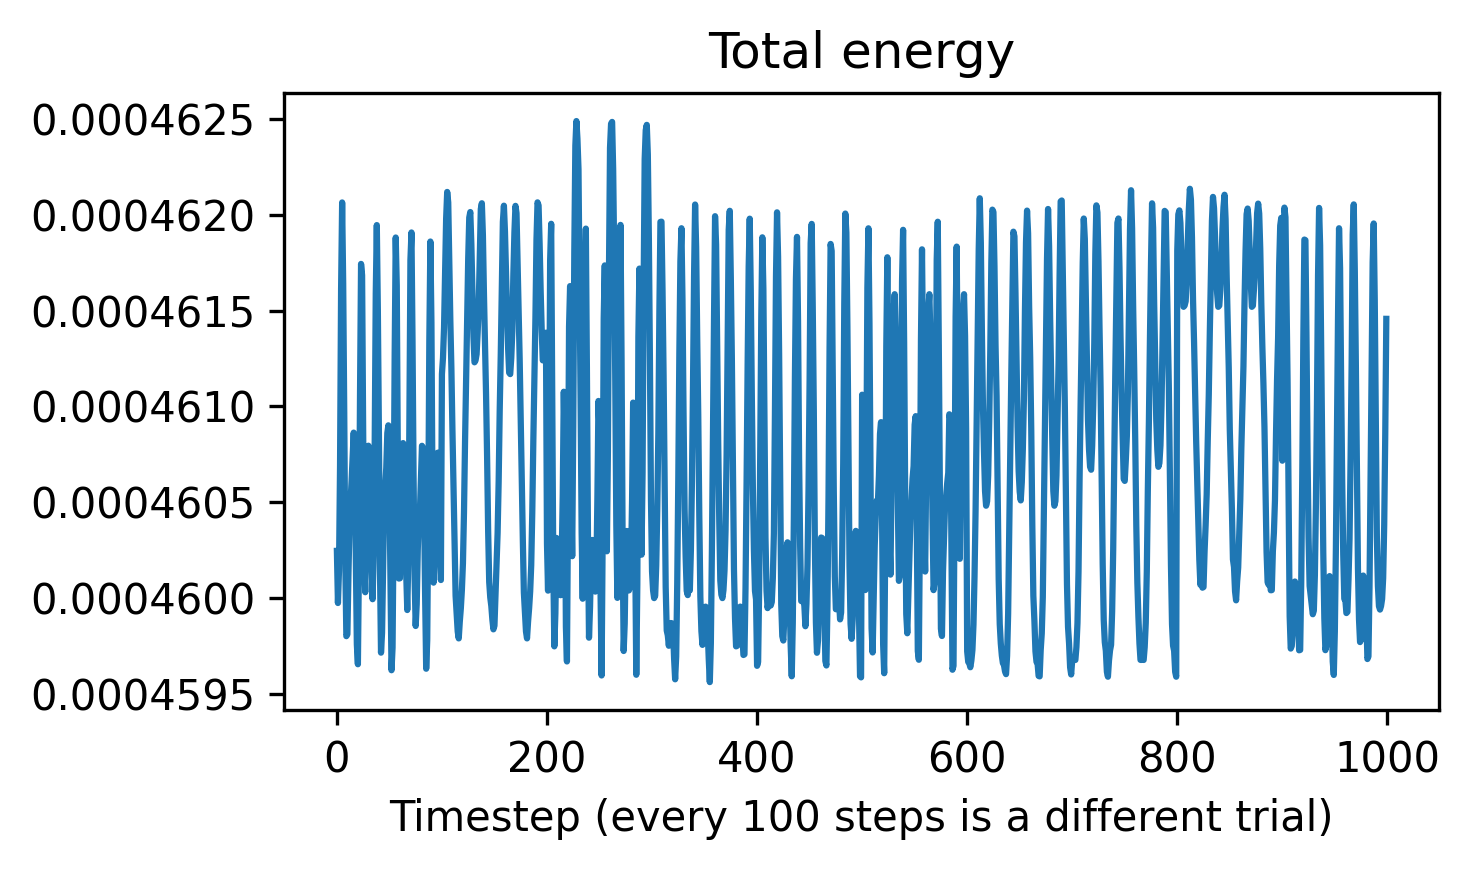

In [11]:
# k = 1000
# fig = plt.figure(figsize=[5,3], dpi=DPI)

# z_values = hnn_model.encode(x[:k])
# F1, F2 = hnn_model.hnn(z_values)
# energy = F2.detach().numpy()
# plt.plot(energy)
# plt.title("Total energy")
# plt.xlabel("Timestep (every {} steps is a different trial)".format(timesteps))
# plt.tight_layout() ; plt.show()
# fig.savefig('{}/total-energy.{}'.format(args.fig_dir, FORMAT))

k = 1000
fig = plt.figure(figsize=[5,3], dpi=DPI)

z_values = hnn_model.encode(x[:k])
F1, F2 = hnn_model.time_derivative(z_values).split(1, dim=1)
energy = F2.detach().numpy()
plt.plot(energy)
plt.title("Total energy")
plt.xlabel("Timestep (every {} steps is a different trial)".format(timesteps))
plt.tight_layout()
plt.show()
fig.savefig('{}/total-energy.{}'.format(args.fig_dir, FORMAT))


## Integrate models in latent space
### Start by getting a real trajectory. Then see how well our models match it

c:\Users\AvinashKumar\.conda\envs\qml_conti\lib\site-packages\gym\utils\passive_env_checker.py:233: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):


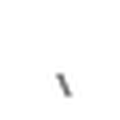

In [12]:
num_frames = 200
test_data = make_gym_dataset(seed=1, timesteps=num_frames+3, trials=1, test_split=0,
                             max_angle=np.pi/10, min_angle=np.pi/11)

# load dataset
side = test_data['meta']['side']

real_pixel_traj = test_data['pixels'][:,:side**2].reshape(-1, side, side)[:num_frames]
name = '{}-truth'.format(args.name)
gifname = make_gif(real_pixel_traj, args.fig_dir, name=name, duration=1e-1, pixels=[120,120])

display.Image(filename=gifname, width=200)

### Integrate models to get a simulated trajectories

In [13]:
# get initial values of latents
x0 = torch.tensor( test_data['pixels'][0:1], dtype=torch.float32)
base_y0 = base_model.encode(x0).detach().numpy().squeeze()
hnn_y0 = hnn_model.encode(x0).detach().numpy().squeeze()

# integrator settings
t_span = [0, 0.98*num_frames]
point_density = num_frames / t_span[-1]
t_eval = np.linspace(t_span[0], t_span[1], num_frames)

# integrate models
# Here we don't compute t_eval[0] because it's the initial state of the system
#   and thus is already known.
base_traj = integrate_model(base_model, t_span, base_y0, t_eval=t_eval[1:])
hnn_traj = integrate_model(hnn_model, t_span, hnn_y0, t_eval=t_eval[1:])

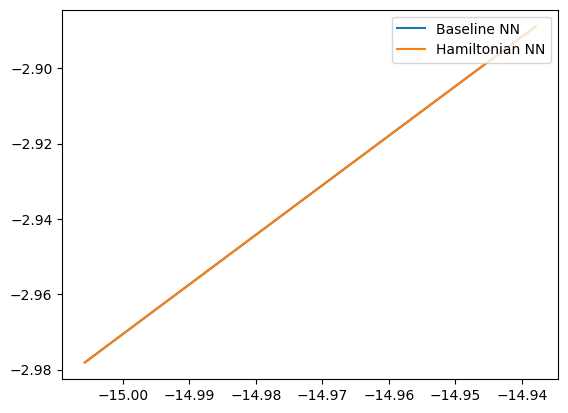

In [21]:
plt.plot(base_traj['y'][0], base_traj['y'][1], label='Baseline NN')
plt.plot(hnn_traj['y'][0], hnn_traj['y'][1], label='Hamiltonian NN')
plt.legend(loc='upper right')
plt.show()

### Decode into latent space and animate

In [15]:
# get initial values of latents
base_zs = torch.tensor( base_traj['y'].T, dtype=torch.float32)
hnn_zs = torch.tensor( hnn_traj['y'].T, dtype=torch.float32)

base_pixel_traj = base_model.decode(base_zs).detach().numpy()
hnn_pixel_traj = hnn_model.decode(hnn_zs).detach().numpy()

_base_pixel_traj = base_pixel_traj[:,:side**2].reshape(-1, side, side)
_hnn_pixel_traj = hnn_pixel_traj[:,:side**2].reshape(-1, side, side)

# set initial values
x0 = real_pixel_traj[0:1]
_hnn_pixel_traj = np.concatenate([x0, _hnn_pixel_traj],axis=0)
_base_pixel_traj = np.concatenate([x0, _base_pixel_traj],axis=0)

trajs = np.concatenate([real_pixel_traj,
                        _base_pixel_traj,
                        _hnn_pixel_traj], axis=-1)

### Add text labels to the GIF

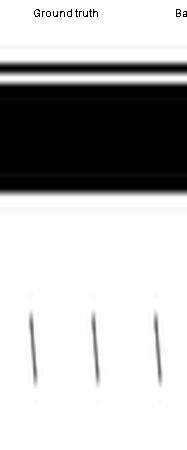

In [17]:
# # add whitespace to top
# frac = 1/4.
# padding = int(frac*side)
# zero_tensor = np.zeros_like(trajs)[:,:padding]
# trajs = np.concatenate([zero_tensor, trajs], axis=1)

# # make and save a GIF
# name = '{}-compare'.format(args.name)
# pixels = [int((1+frac)*150), 3*150] # dimensions of GIF in pixels
# gifname = make_gif(trajs, args.fig_dir, name=name, duration=1e-1, pixels=pixels, divider=padding)

# # reload GIF and add text labels to it
# im = Image.open(gifname)
# frames = []
# # Loop over each frame in the animated image
# for frame in ImageSequence.Iterator(im):
#     # Draw the text on the frame
#     d = ImageDraw.Draw(frame)
#     font = ImageFont.truetype("/Library/Fonts/Arial.ttf", 18)
#     d.text((33,7), "Ground truth", font=font)
#     d.text((175,7), "Baseline NN", font=font)
#     d.text((310,7), "Hamiltonian NN", font=font)
#     del d

#     # Saving the image without 'save_all' will turn it into a single frame image, and we can then re-open it
#     # To be efficient, we will save it to a stream, rather than to file
#     b = io.BytesIO()
#     frame.save(b, format="GIF")
#     frame = Image.open(b)

#     # Then append the single frame image to a list of frames
#     frames.append(frame)
# # Save the frames as a new image
# name = "{}/{}-compare-labeled.gif".format(args.fig_dir, args.name)
# frames[0].save(name, save_all=True, append_images=frames[1:])

# display.Image(filename=name, width=400)

# add whitespace to top
frac = 1/4.
padding = int(frac*side)
zero_tensor = np.zeros_like(trajs)[:,:padding]
trajs = np.concatenate([zero_tensor, trajs], axis=1)

# make and save a GIF
name = '{}-compare'.format(args.name)
pixels = [int((1+frac)*150), 3*150] # dimensions of GIF in pixels
gifname = make_gif(trajs, args.fig_dir, name=name, duration=1e-1, pixels=pixels, divider=padding)

# reload GIF and add text labels to it
im = Image.open(gifname)
frames = []
# Loop over each frame in the animated image
for frame in ImageSequence.Iterator(im):
    # Draw the text on the frame
    d = ImageDraw.Draw(frame)
    try:
        font = ImageFont.truetype("/Library/Fonts/Arial.ttf", 18)
    except OSError:
        font = ImageFont.load_default()
    d.text((33,7), "Ground truth", font=font)
    d.text((175,7), "Baseline NN", font=font)
    d.text((310,7), "Hamiltonian NN", font=font)
    del d

    # Saving the image without 'save_all' will turn it into a single frame image, and we can then re-open it
    # To be efficient, we will save it to a stream, rather than to file
    b = io.BytesIO()
    frame.save(b, format="GIF")
    frame = Image.open(b)

    # Then append the single frame image to a list of frames
    frames.append(frame)
# Save the frames as a new image
name = "{}/{}-compare-labeled.gif".format(args.fig_dir, args.name)
frames[0].save(name, save_all=True, append_images=frames[1:])

display.Image(filename=name, width=400)


### We can also add energy via integration of the HNN

In [22]:
def hnn_conserve_energy(t, np_x):
    x = torch.tensor( np_x, requires_grad=True, dtype=torch.float32)
    x = x.view(1, np.size(np_x))
    dx = hnn_model.time_derivative(x).data.numpy().reshape(-1)
    return dx
    
def hnn_add_energy(t, np_x):
    x = torch.tensor( np_x, requires_grad=True, dtype=torch.float32)
    x = x.view(1, np.size(np_x)) # batch size of 1
    _, F2 = hnn_model.hnn(x)
    dx = torch.autograd.grad(F2.sum(), x, create_graph=True)[0]
    np_dx = dx.data.numpy().reshape(-1)
    return np_dx

In [24]:
frames = 500

t_span1, t_span2, t_span3 = [0,50.], [0,1.4], [0,60]
t_tot = t_span1[-1] + t_span2[-1] + t_span3[-1]
point_density = frames/t_tot
t_evals = lambda t_span: int( (t_span[1] - t_span[0])*point_density )

y0 = np.asarray([.8, 0])
kwargs = {'t_eval': np.linspace(t_span1[0], t_span1[1], t_evals(t_span1))}
path1 = integrate_model(hnn_model, t_span1, y0, fun=hnn_conserve_energy, **kwargs)

y0 = path1['y'][:,-1]
kwargs = {'t_eval': np.linspace(t_span2[0], t_span2[1], t_evals(t_span2)), 'rtol': 1e-12}
path2 = integrate_model(hnn_model, t_span2, y0, fun=hnn_add_energy, **kwargs)

y0 = path2['y'][:,-1]
kwargs = {'t_eval': np.linspace(t_span3[0], t_span3[1], t_evals(t_span3))}
path3 = integrate_model(hnn_model, t_span3, y0, fun=hnn_conserve_energy, **kwargs)

y = np.concatenate([path1['y'], path2['y'], path3['y']], axis=-1).T

# y.shape[0] % LINE_SEGMENTS should be 0
terminal_ix = LINE_SEGMENTS * (y.shape[0]//LINE_SEGMENTS)
y = y[:terminal_ix]

AttributeError: 'PixelHNN' object has no attribute 'hnn'

### Visualize integration

NameError: name 'y' is not defined

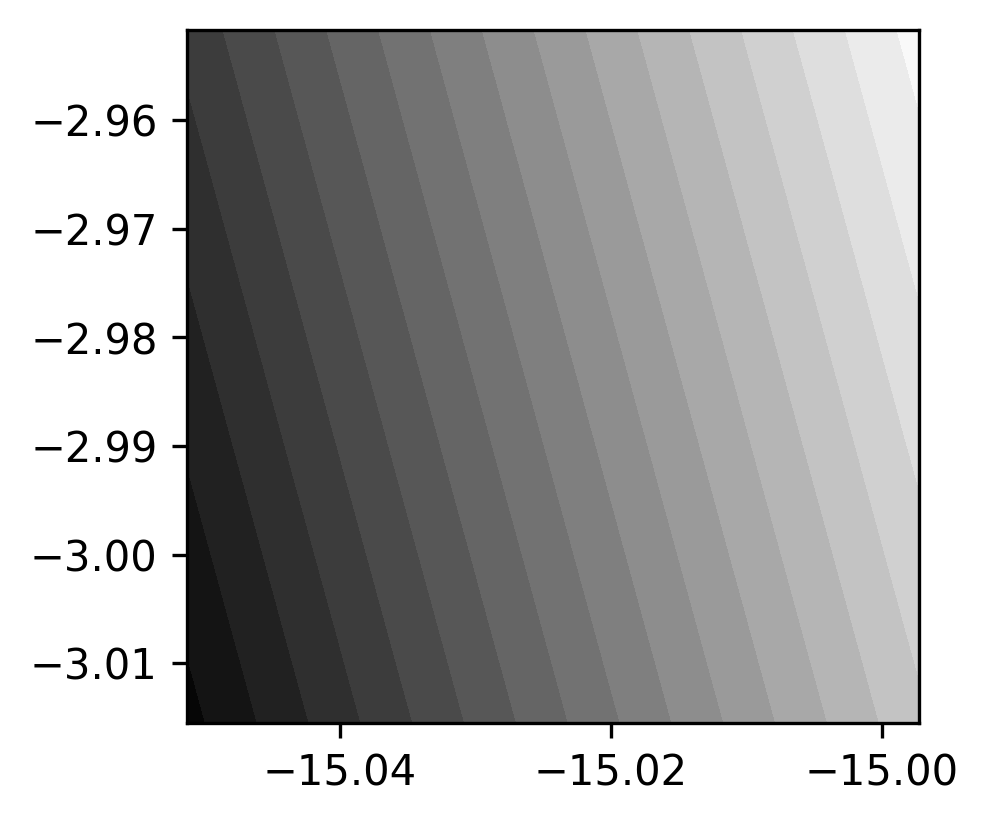

In [20]:
fig = plt.figure(figsize=(3.15, 3), facecolor='white', dpi=DPI)

ax = fig.add_subplot(1, 1, 1, frameon=True)
plt.contourf(gX, gV, np_F2, cmap='gray_r', levels=20)
for i, l in enumerate(np.split(y, LINE_SEGMENTS)):
    
    color = (float(i)/LINE_SEGMENTS, 0, 1-float(i)/LINE_SEGMENTS)
    label = None
    if i==0:
        label = 'Initial t'
    elif i==LINE_SEGMENTS-1:
        label = 'Final t'
    ax.plot(l[:,0],l[:,1],color=color, linewidth=LINE_WIDTH, label=label)
plt.legend(fontsize=8)

ax.set_xlabel("$x_0$") ; ax.set_ylabel("$x_1$")
# ax.set_title("Integrating HNN in latent space")

ax.set_xlabel("$z_0$ (analogous to $\\theta$)")
ax.set_ylabel("$z_1 \\approx \dot z_0$ (analogous to $\dot \\theta$)")

plt.tight_layout() ; plt.show()
fig.savefig('{}/integrate-latent-hnn.{}'.format(args.fig_dir, FORMAT))

### Project back into pixel space and render

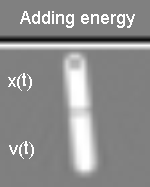

In [36]:
# back to pixel space
y_gif = y[::2]
simulated_latents = torch.tensor( y_gif, dtype=torch.float32)
simulated_pixels = hnn_model.decode(simulated_latents)
addenergy_traj = simulated_pixels.data.numpy()[:,:side**2].reshape(-1,side,side)

# add whitespace to top
frac = 1/4.
padding = int(frac*side)
zero_tensor = np.zeros_like(addenergy_traj)[:,:padding]
addenergy_traj = np.concatenate([zero_tensor, addenergy_traj], axis=1)

# make and save a GIF
name = '{}-addenergy'.format(args.name)
pixels = [int((1+frac)*150), 1*150] # dimensions of GIF in pixels
gifname = make_gif(addenergy_traj, args.fig_dir, name=name, duration=5e-2, pixels=pixels, divider=padding)

# reload GIF and add text labels to it
im = Image.open(gifname)
frames = []
# Loop over each frame in the animated image
for frame in ImageSequence.Iterator(im):
    # Draw the text on the frame
    d = ImageDraw.Draw(frame)
    font = ImageFont.truetype("/Library/Fonts/Arial.ttf", 18)
    d.text((20,7), "Adding energy", font=font)
    d.text((8,70), "x(t)", font=font)
    d.text((8,138), "v(t)", font=font)
    del d

    # Saving the image without 'save_all' will turn it into a single frame image, and we can then re-open it
    # To be efficient, we will save it to a stream, rather than to file
    b = io.BytesIO()
    frame.save(b, format="GIF")
    frame = Image.open(b)

    # Then append the single frame image to a list of frames
    frames.append(frame)
# Save the frames as a new image
name = "{}/{}-addenergy-labeled.gif".format(args.fig_dir, args.name)
frames[0].save(name, save_all=True, append_images=frames[1:])

display.Image(filename=name, width=130)

## Evaluate energy in a qualitative way
This is a bit tricky, since we've learned everything straight from pixels. But we'll do our best.

First, we need to learn a linear mapping from $z$-space to canonical coordinates. We'll do this so that we can measure (approximately) the energy of the trajectories we integrated above.

In [20]:
def learn_z2canonical(pixels, coords, model, train_steps=4000):
    '''Learn mapping from z space to canonical coordinates'''
    cc = torch.tensor( coords, dtype=torch.float32) # canonical coords
    x = torch.tensor( pixels, dtype=torch.float32) # pixels
    z = model.encode(x).detach()
    
    z2cc = torch.nn.Linear(2,2) # linear layer that we're going to learn // could also use MLP(2,50,2)
    optim = torch.optim.Adam(z2cc.parameters(), args.learn_rate)
    
    for i in range(train_steps+1):
        ixs = torch.randperm(z.shape[0])[:400]
        loss = L2_loss(z2cc(z[ixs]), cc[ixs])
        loss.backward() ; optim.step() ; optim.zero_grad()
        if i % 1000 ==0:
            print("step {}, train_loss {:.4e}".format(i, loss.item()))
    return z2cc

def pix2cc(model, pixels, z2cc=None):
    if z2cc is None:
        z2cc = learn_z2canonical(data['pixels'], data['coords'], model)
        
    x = torch.tensor( pixels, dtype=torch.float32)
    z = hnn_model.encode(x)
    cc = z2cc(z).detach().numpy()
    return cc

#### ESTIMATE CANONICAL COORDINATES
true_cc = test_data['coords']
print('Getting Baseline NN canonical coords')
base_cc = pix2cc(base_model, base_pixel_traj)
print('\nGetting Hamiltonian NN canonical coords')
hnn_cc = pix2cc(hnn_model, hnn_pixel_traj)

y0 = true_cc[0:1]
base_cc = np.concatenate([y0, base_cc], axis=0)
hnn_cc = np.concatenate([y0, hnn_cc], axis=0)

#### USE THEM TO ESTIMATE TOTAL ENERGY
true_e = np.stack([hamiltonian_fn(c) for c in true_cc])
base_e = np.stack([hamiltonian_fn(c) for c in base_cc])
hnn_e = np.stack([hamiltonian_fn(c) for c in hnn_cc])

Getting Baseline NN canonical coords
step 0, train_loss 6.0504e-01
step 1000, train_loss 3.6650e-03
step 2000, train_loss 7.9852e-05
step 3000, train_loss 7.1416e-05
step 4000, train_loss 4.9720e-05

Getting Hamiltonian NN canonical coords
step 0, train_loss 3.8135e-01
step 1000, train_loss 1.8683e-02
step 2000, train_loss 3.2128e-03
step 3000, train_loss 3.6955e-04
step 4000, train_loss 9.6420e-05


## Make a principled plot of pendulum rollout + energies

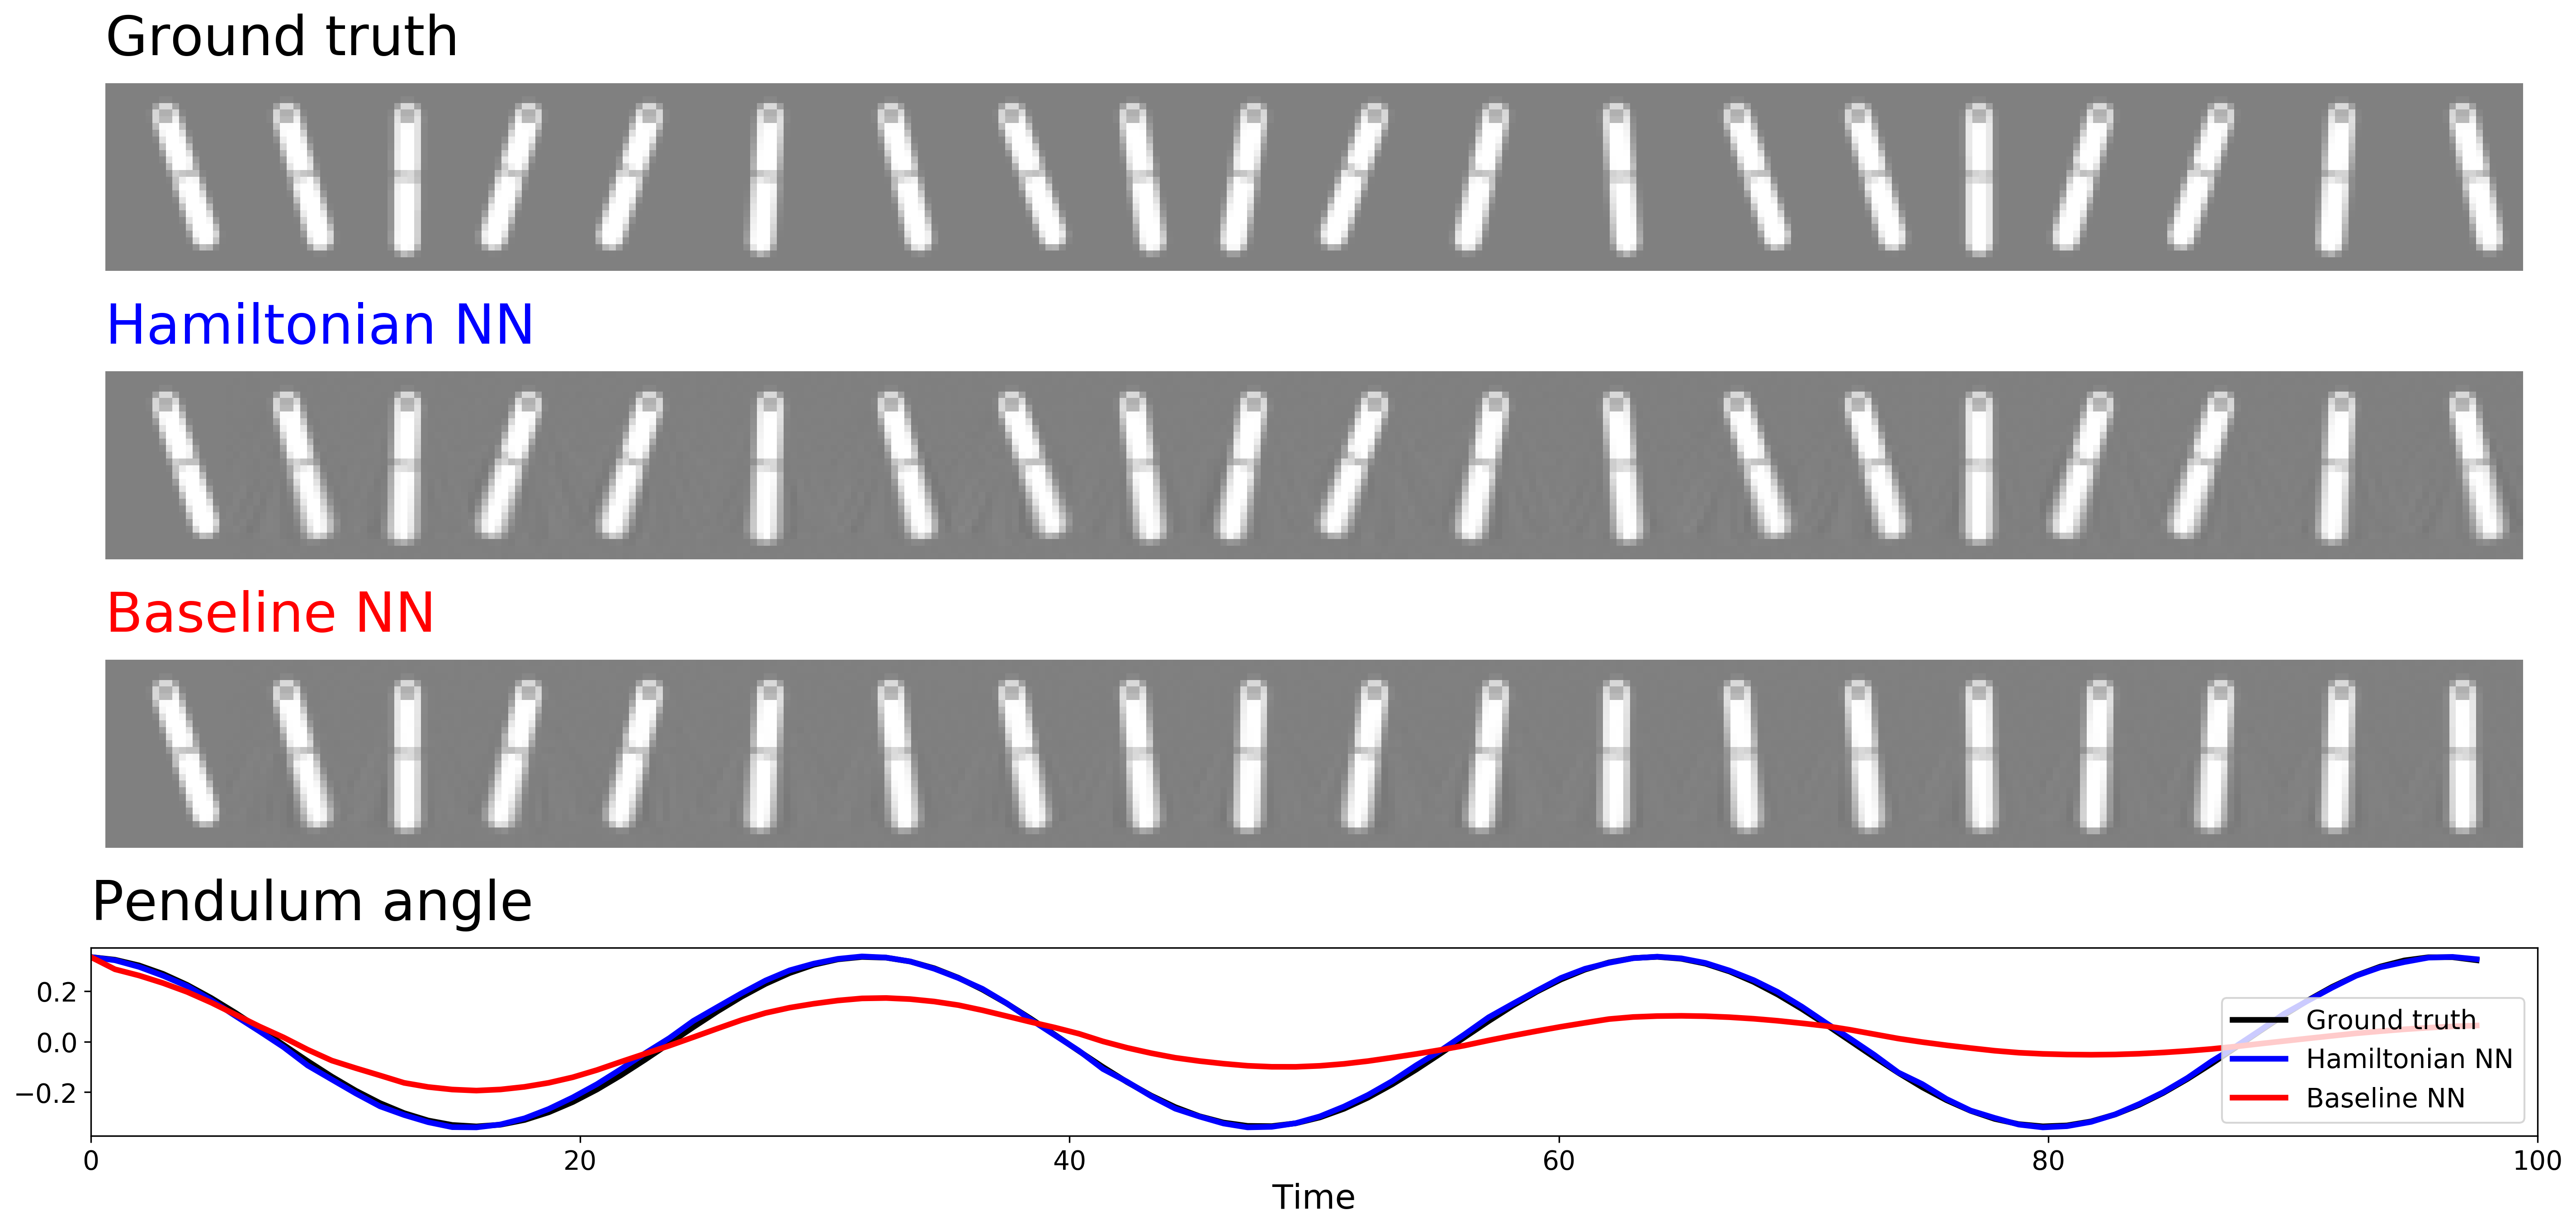

In [21]:
N = 18
tmax = 100
b = 5
k = tmax // N
true_seq = real_pixel_traj[:tmax][::k,...,b:-b].transpose(1,0,2).reshape(28,-1)
true_seq = (true_seq.clip(-.5,.5) + .5)*255

hnn_seq = _hnn_pixel_traj[:tmax][::k,...,b:-b].transpose(1,0,2).reshape(28,-1)
hnn_seq = (hnn_seq.clip(-.5,.5) + .5)*255

base_seq = _base_pixel_traj[:tmax][::k,...,b:-b].transpose(1,0,2).reshape(28,-1)
base_seq = (base_seq.clip(-.5,.5) + .5)*255

sy = 3
sx = .55*sy*(28.-2*b)/28

#### USE THEM TO ESTIMATE TOTAL ENERGY
true_e = np.stack([hamiltonian_fn(c) for c in true_cc])
base_e = np.stack([hamiltonian_fn(c) for c in base_cc])
hnn_e = np.stack([hamiltonian_fn(c) for c in hnn_cc])

fs = 29 # font size
fig = plt.figure(figsize=[sx*N,3*sy], dpi=300)

plt.subplot(4,1,1)
plt.imshow(true_seq, cmap='gray')
plt.title('Ground truth', fontsize=fs, pad=15, loc='left')
plt.clim(0,255) ; plt.axis('off')

plt.subplot(4,1,2)
plt.imshow(hnn_seq, cmap='gray')
plt.title('Hamiltonian NN', fontsize=fs, pad=15, loc='left', color='b')
plt.clim(0,255) ; plt.axis('off')

plt.subplot(4,1,3)
plt.imshow(base_seq, cmap='gray')
plt.title('Baseline NN', fontsize=fs, pad=15, loc='left', color='r')
plt.clim(0,255) ; plt.axis('off')

plt.subplot(4,1,4)
plt.title('Pendulum angle', fontsize=fs, pad=15, loc='left')

plt.plot(t_eval[:tmax], true_cc[:tmax,0], 'k-', label='Ground truth', linewidth=3)
plt.plot(t_eval[:tmax], hnn_cc[:tmax,0], 'b-', label='Hamiltonian NN', linewidth=3)
plt.plot(t_eval[:tmax], base_cc[:tmax,0], 'r-', label='Baseline NN', linewidth=3)
plt.xlabel('Time', fontsize=18)
plt.xticks(fontsize=14) ; plt.yticks(fontsize=14)
plt.legend(fontsize=14, loc='lower right')
plt.xlim(0, tmax)

plt.tight_layout() ; plt.show()
fig.savefig('{}/pendulum-compare-static.{}'.format(args.fig_dir, FORMAT))

## Analyze conserved quantities even more thoroughly

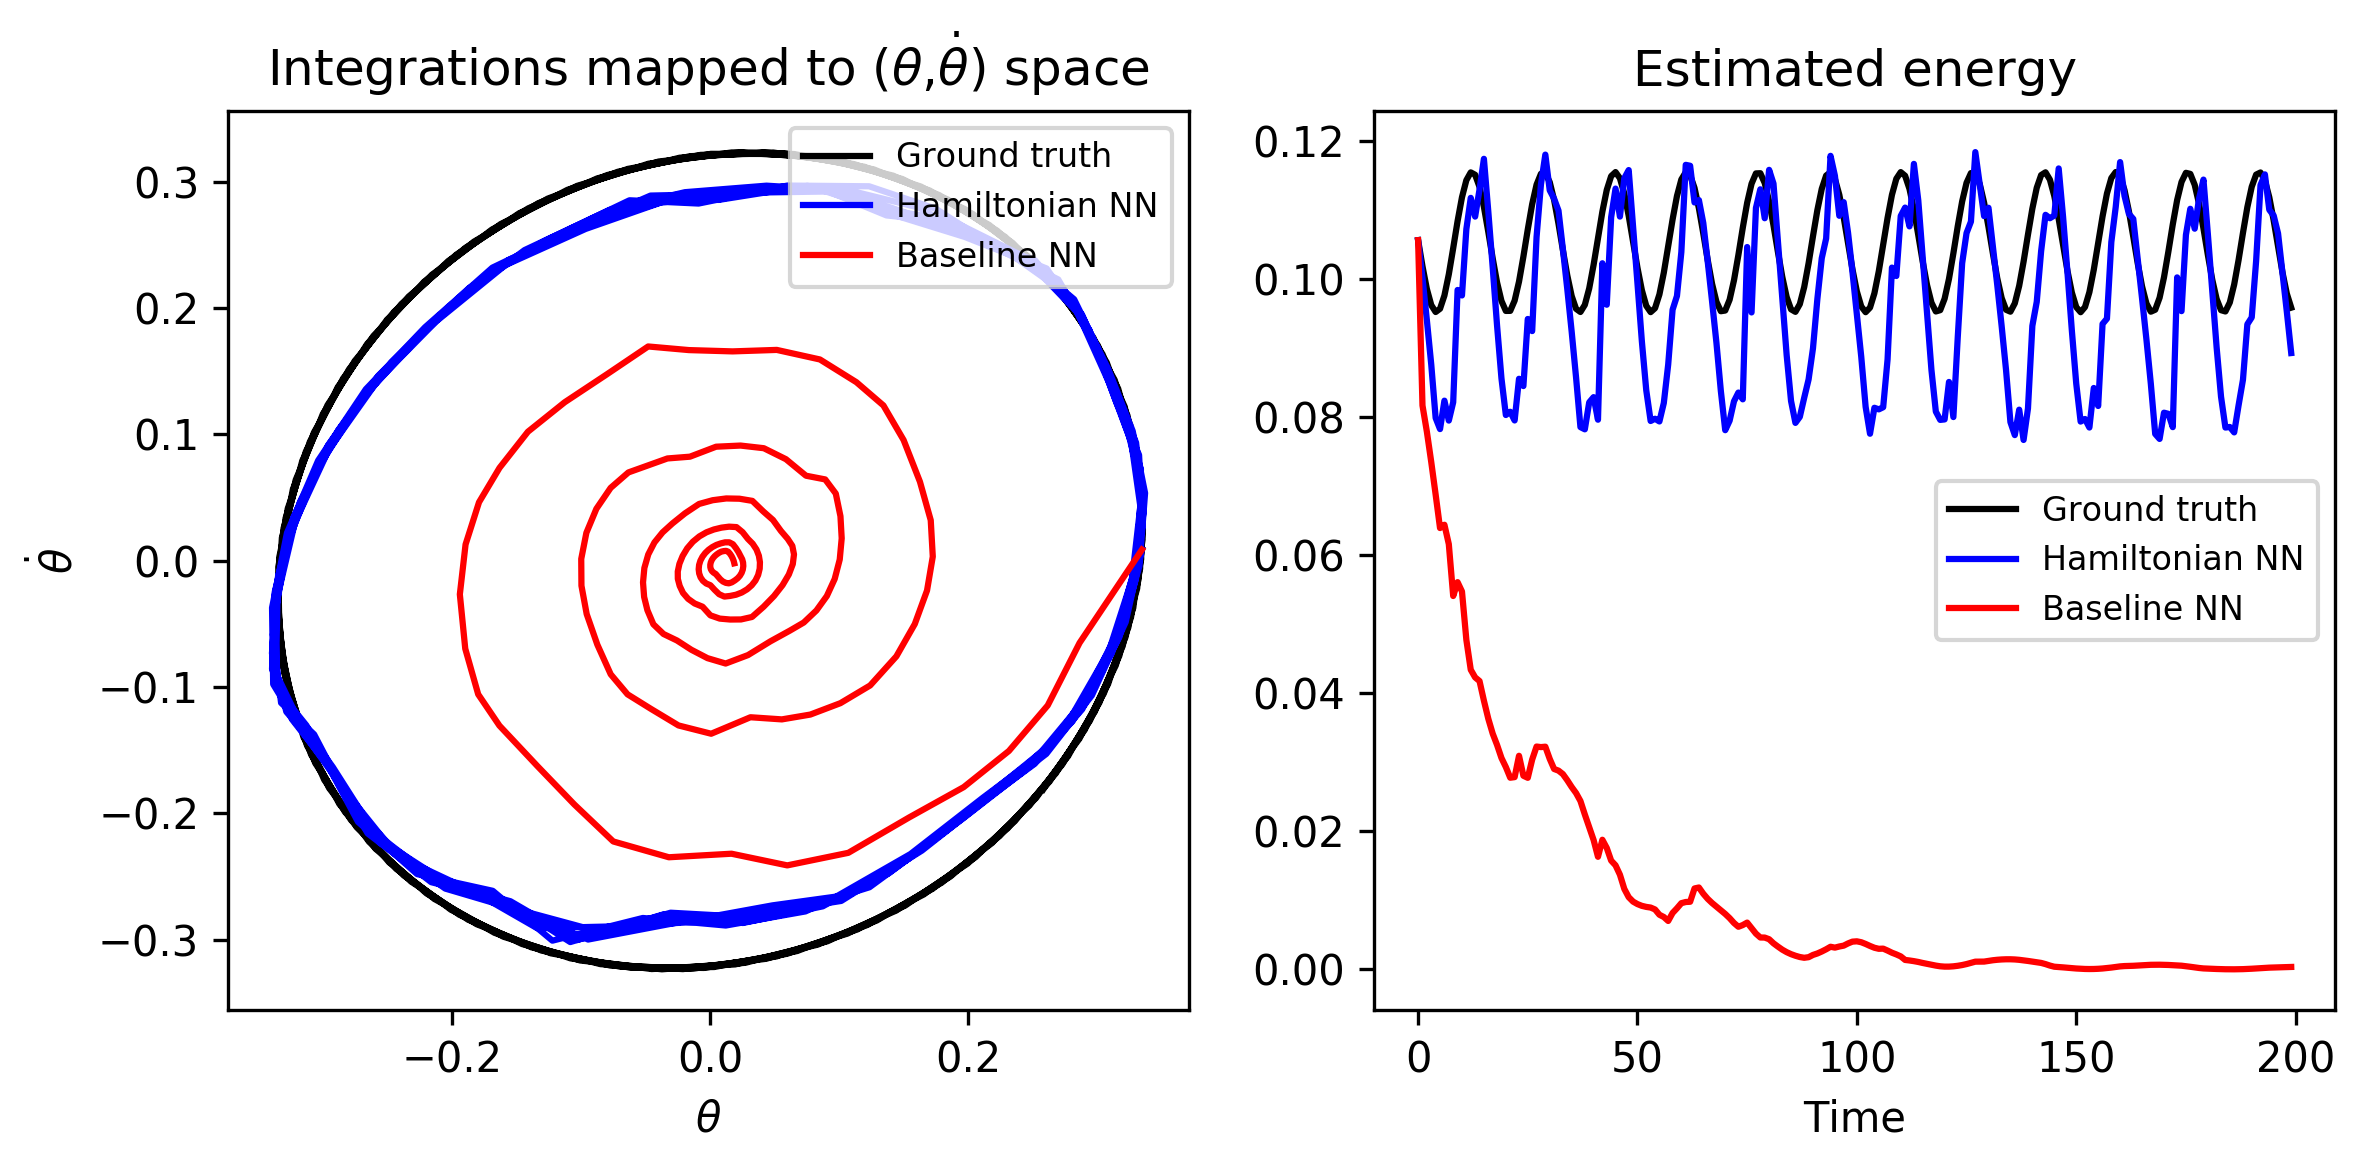

In [22]:
# plot trajectories in cc-space
fig = plt.figure(figsize=[8,4], dpi=DPI)
plt.subplot(1,2,1)
plt.title('Integrations mapped to ($\\theta$,$\dot \\theta$) space'.format(args.name))
plt.xlabel("$\\theta$") ; plt.ylabel("$\dot \\theta$")

plt.plot(test_data['coords'][:,0], test_data['coords'][:,1], 'k-', label='Ground truth')
plt.plot(hnn_cc[:,0], hnn_cc[:,1], 'b-', label='Hamiltonian NN')
plt.plot(base_cc[:,0], base_cc[:,1], 'r-', label='Baseline NN')

# plt.xlim(-.5,.5) ; plt.ylim(-1.5,2.3)
plt.legend(fontsize=8, loc='upper right')

# plot estimated energy
plt.subplot(1,2,2)
plt.title('Estimated energy') ; plt.xlabel('Time')
plt.plot(true_e, 'k', label='Ground truth')
plt.plot(hnn_e, 'b', label='Hamiltonian NN')
plt.plot(base_e, 'r', label='Baseline NN')
plt.legend(fontsize=8)

plt.tight_layout() ; plt.show()
fig.savefig('{}/pixhnn-energy.{}'.format(args.fig_dir, FORMAT))

## Quantitative analysis

In [24]:
bootstrap_conf = lambda x, splits=5: np.std([np.mean(x_i) for x_i in np.split(x, splits)])/np.sqrt(splits)

def np_L2_dist(x, xhat):
    return (x-xhat)**2

base_distance = np_L2_dist(true_e, base_e)
hnn_distance = np_L2_dist(true_e, hnn_e)

splits = 5
print("\nBaseline NN energy MSE: {:.4e} +/- {:.2e}\nHamiltonian NN energy MSE: {:.4e} +/- {:.2e}"
      .format(
          np.mean(base_distance), bootstrap_conf(base_distance, splits),
          np.mean(hnn_distance), bootstrap_conf(hnn_distance, splits))
     )


Baseline NN energy MSE: 9.2748e-03 +/- 1.14e-03
Hamiltonian NN energy MSE: 1.5315e-04 +/- 8.42e-06
